# Building alternative pipeline

* Prepare Hough transform based only on wire information (= energy, time, radial distance)
* Build predictions based on Hough, local information, and local information of left/right neighbors


In [13]:
%run visualizations.ipynb
import sys
sys.path.insert(0, '../modules')

Populating the interactive namespace from numpy and matplotlib


In [14]:
from hits import AllHits
hits = AllHits('../data/signal.root')

In [15]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import linear_model

In [16]:
def get_circle(x_coeff, y_coeff, intercept):
    return x_coeff/2, y_coeff/2, np.sqrt(4*intercept + x_coeff**2 + y_coeff**2)/2

In [17]:
# each hit point scored by how many times it is useful in completeing a ciruclar fit.  RANSAC "voting"
# random 

Event 0
Fit:32.7493132261
RANSAC Fit:32.7493132261

Fit:33.2496092687
RANSAC Fit:33.2496092687



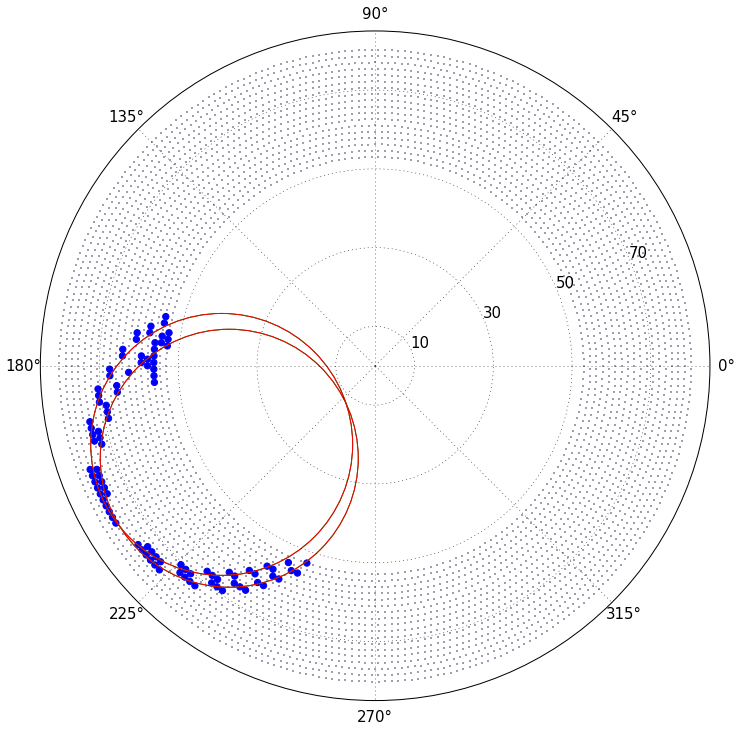

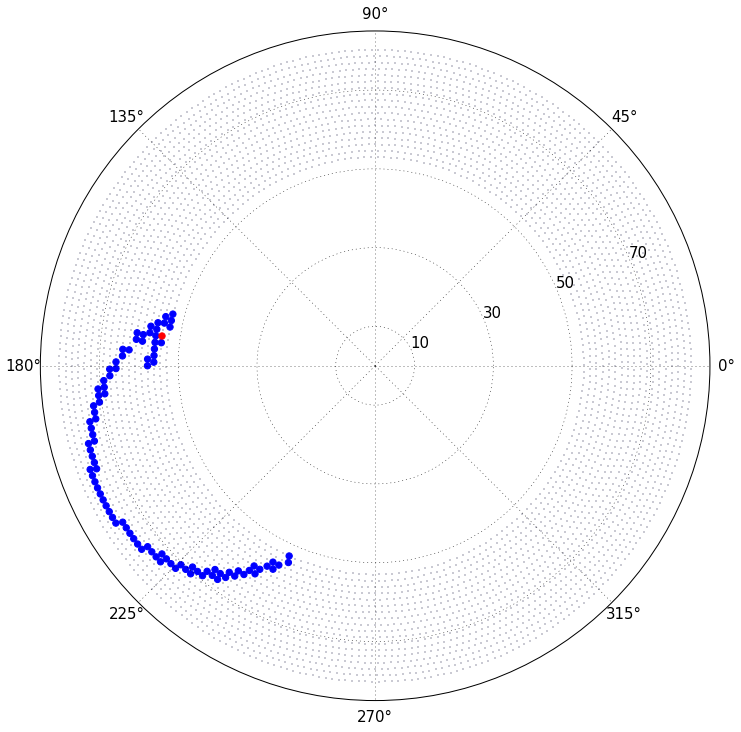

Event 1
Fit:33.9307322735
RANSAC Fit:34.5676572915

Fit:34.5862914587
RANSAC Fit:34.5862914587



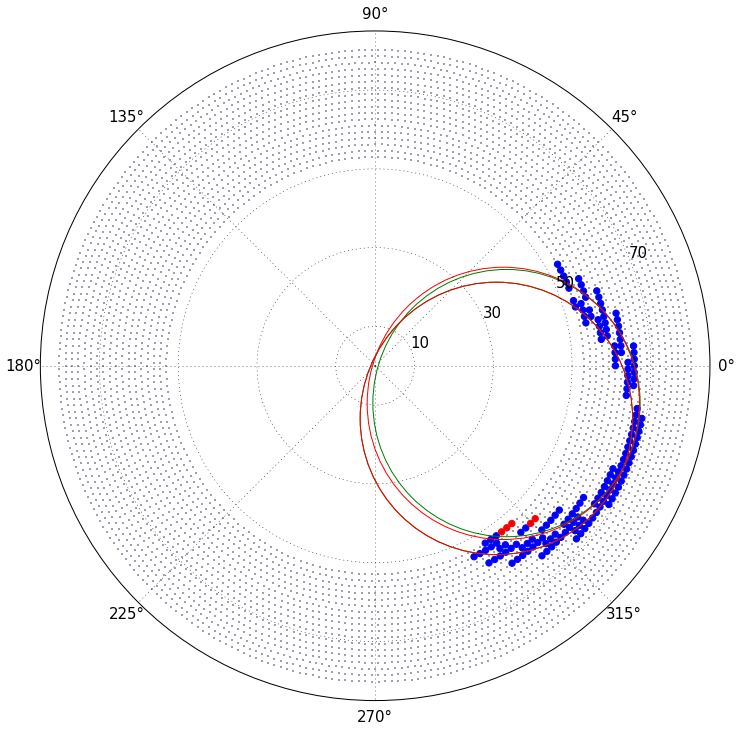

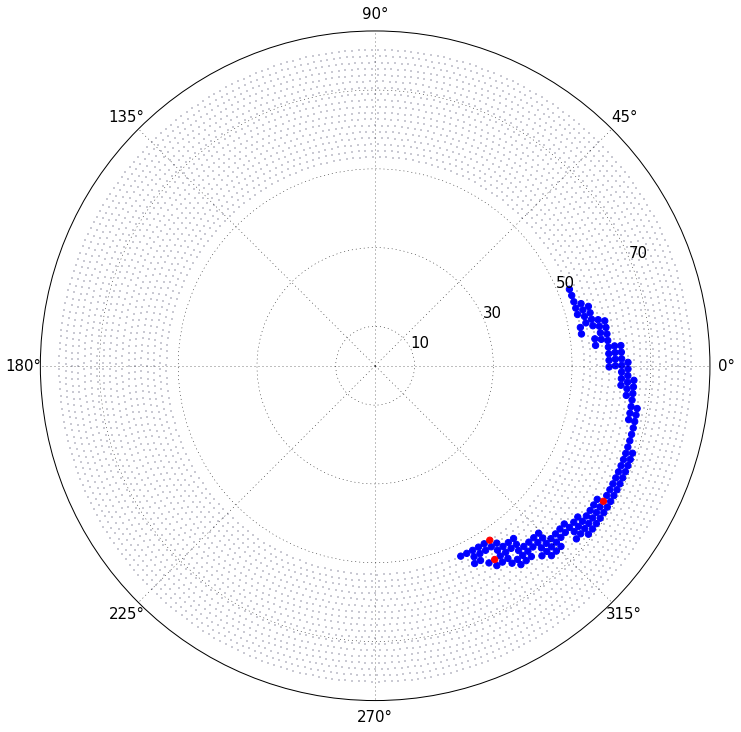

Event 2
Fit:31.0984459789
RANSAC Fit:31.0984459789

Fit:27.1842951748
RANSAC Fit:27.1842951748



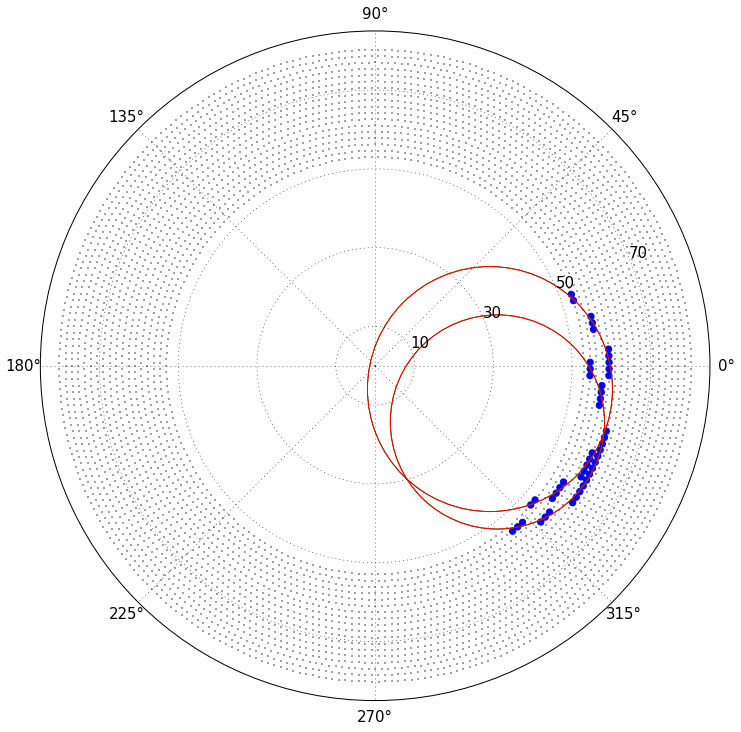

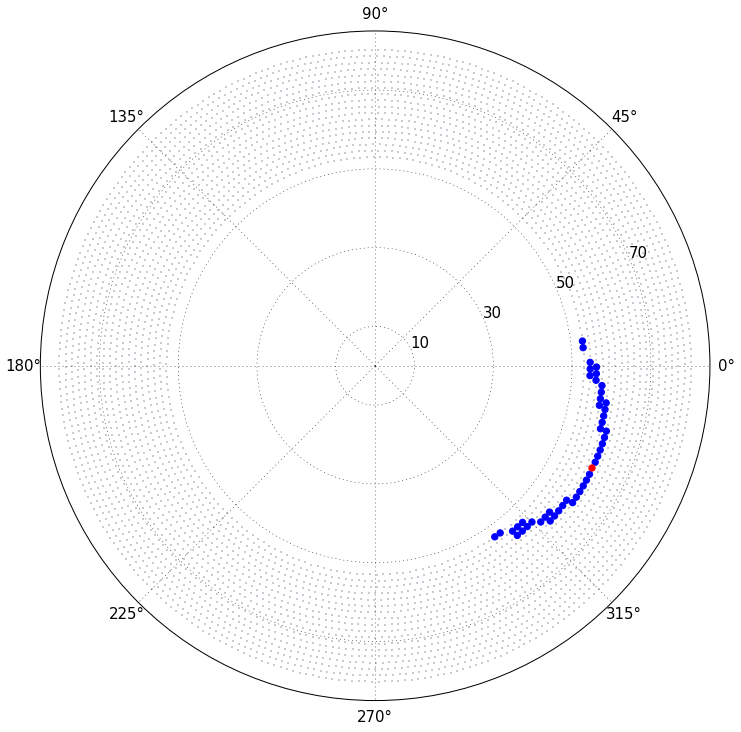

Event 3
Fit:32.1858600492
RANSAC Fit:32.1858600492

Fit:33.5677404511
RANSAC Fit:33.5677404511



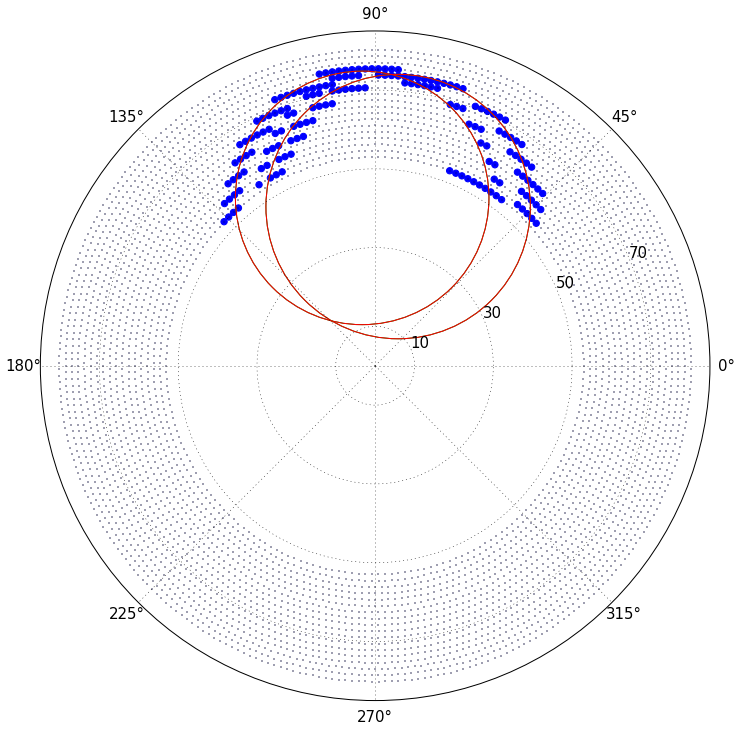

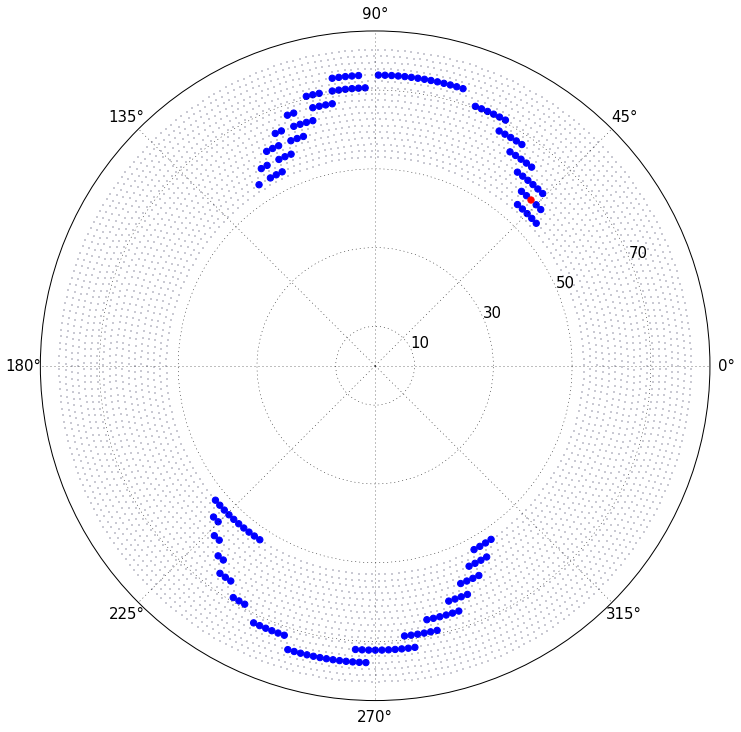

Event 4
Fit:30.31731678
RANSAC Fit:31.3462954101

Fit:31.1800515849
RANSAC Fit:33.3034906333



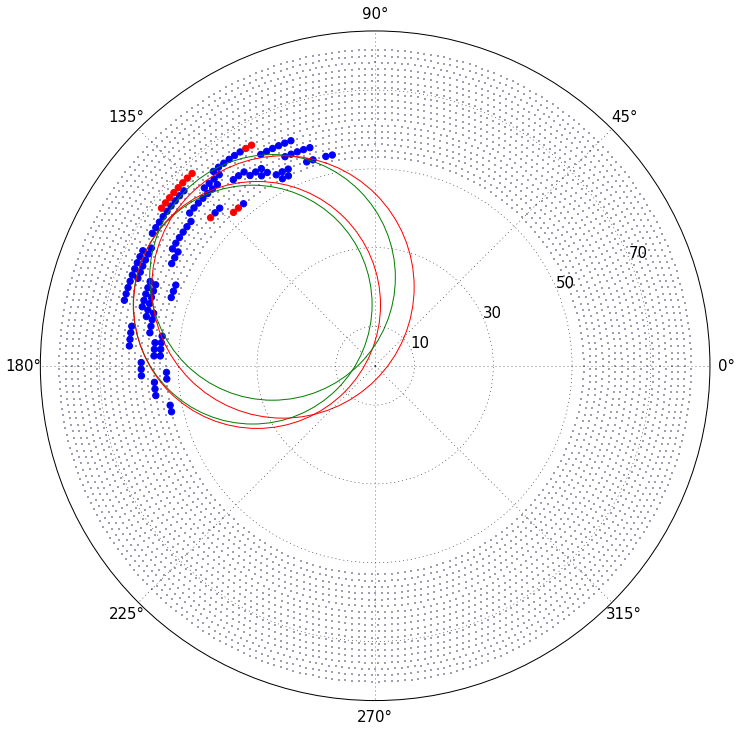

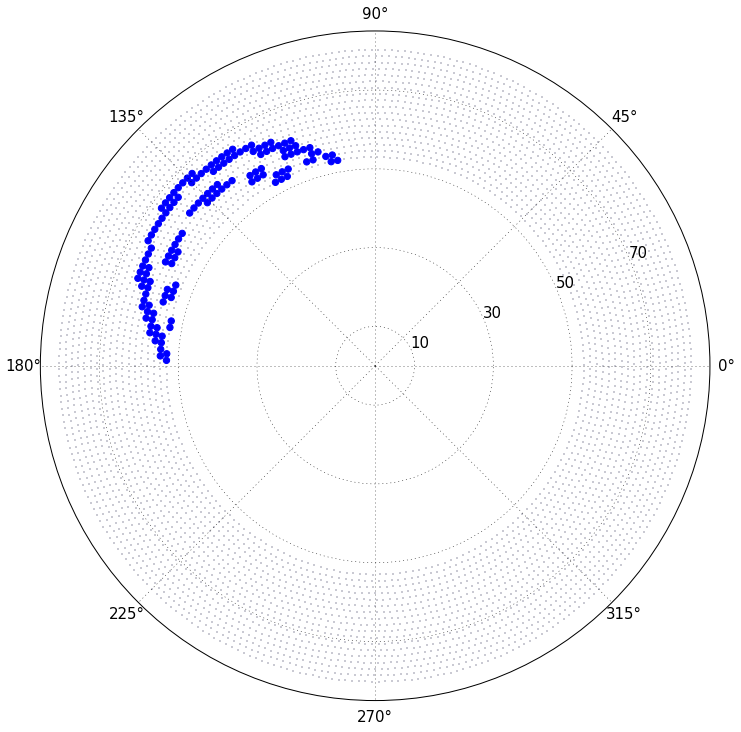

Event 5
Fit:36.5216199757
RANSAC Fit:36.4732207113

Fit:35.4790265183
RANSAC Fit:35.1888389854



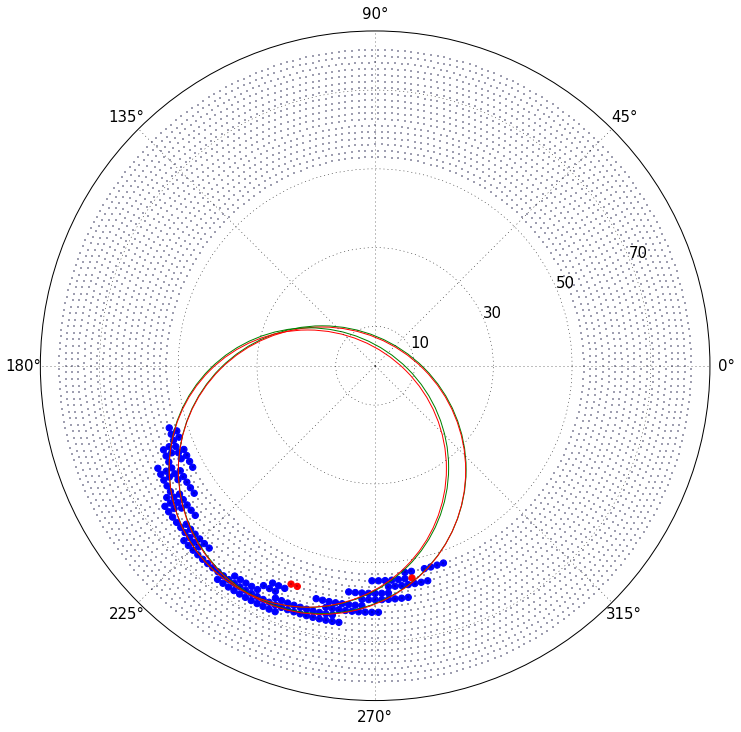

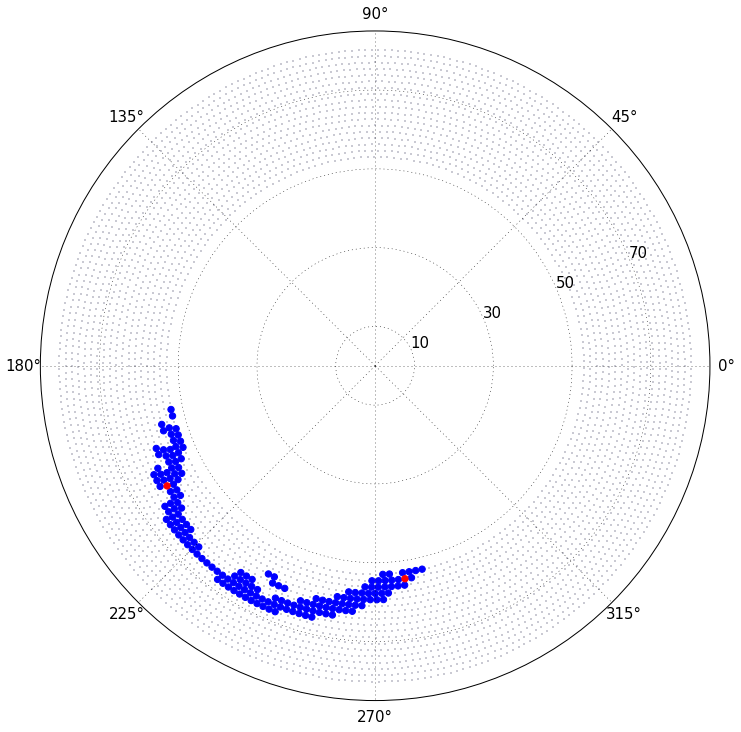

Event 6
Fit:32.1062454004
RANSAC Fit:33.1493824913

Fit:64.181751256
RANSAC Fit:57.8



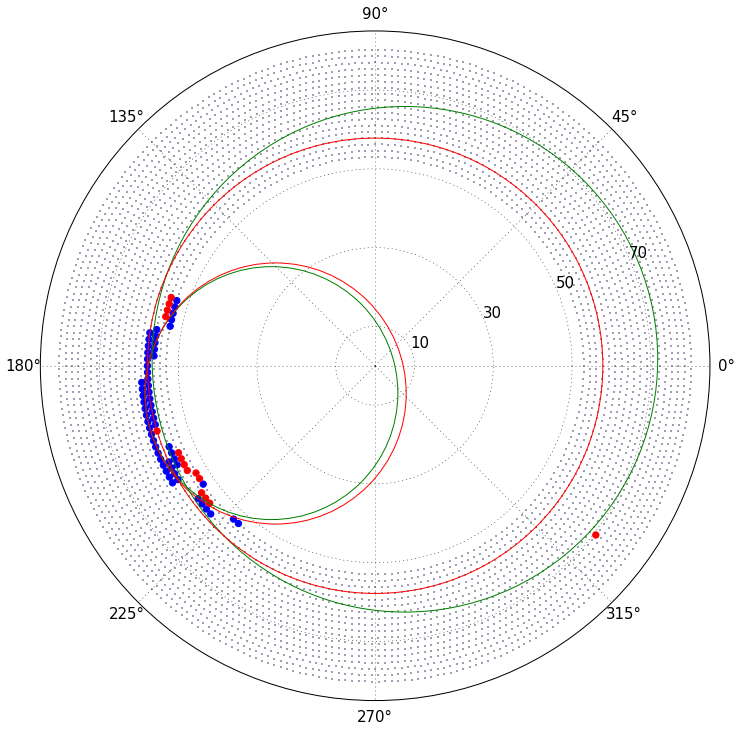

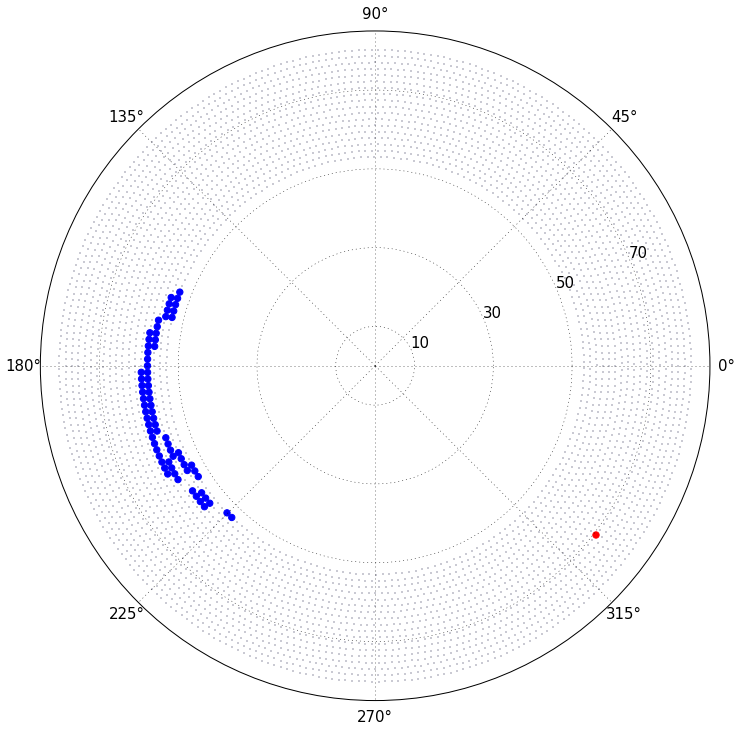

Event 7
Fit:23.292260818
RANSAC Fit:59.4

Fit:24.8443927617
RANSAC Fit:54.6



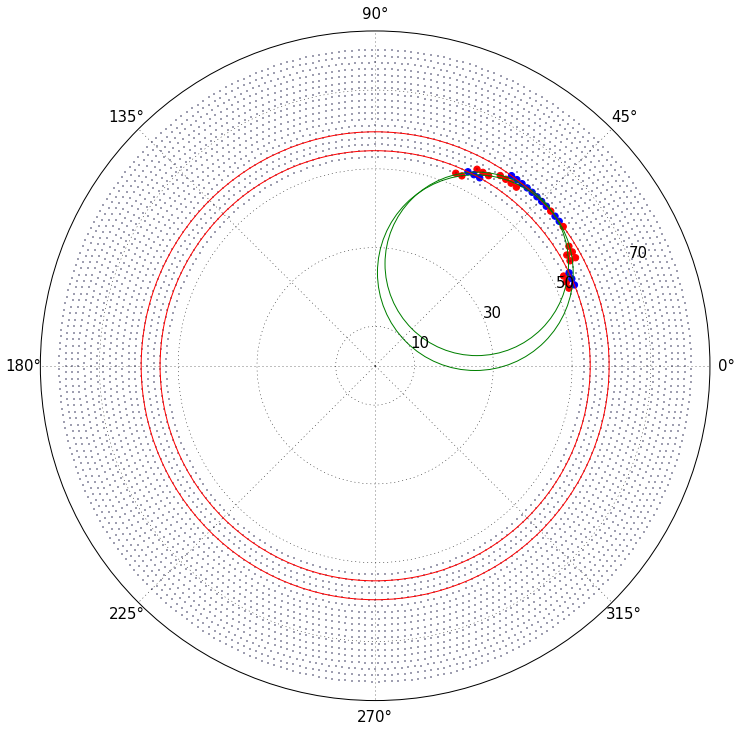

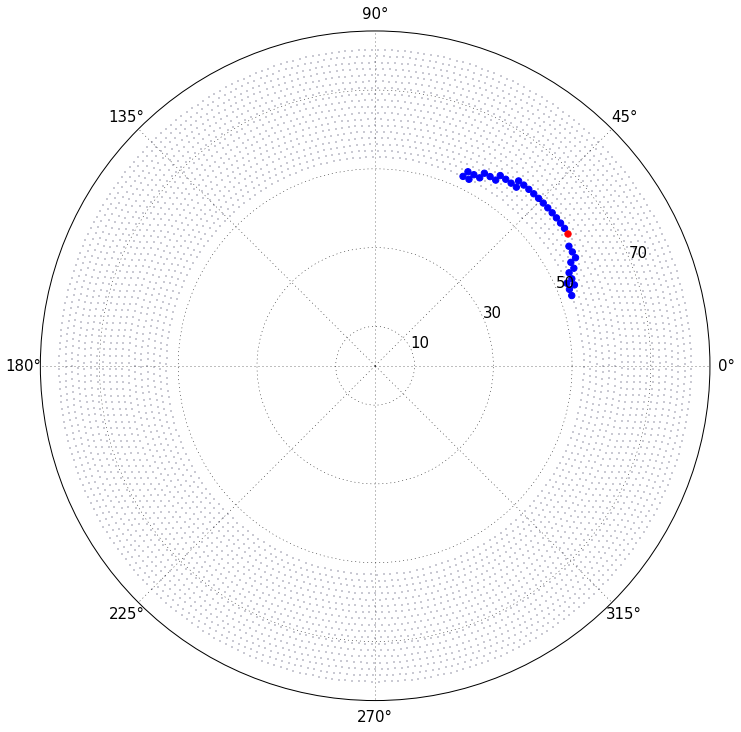

Event 8
Fit:31.5945731819
RANSAC Fit:31.5945731819

Fit:28.3171098585
RANSAC Fit:61.0



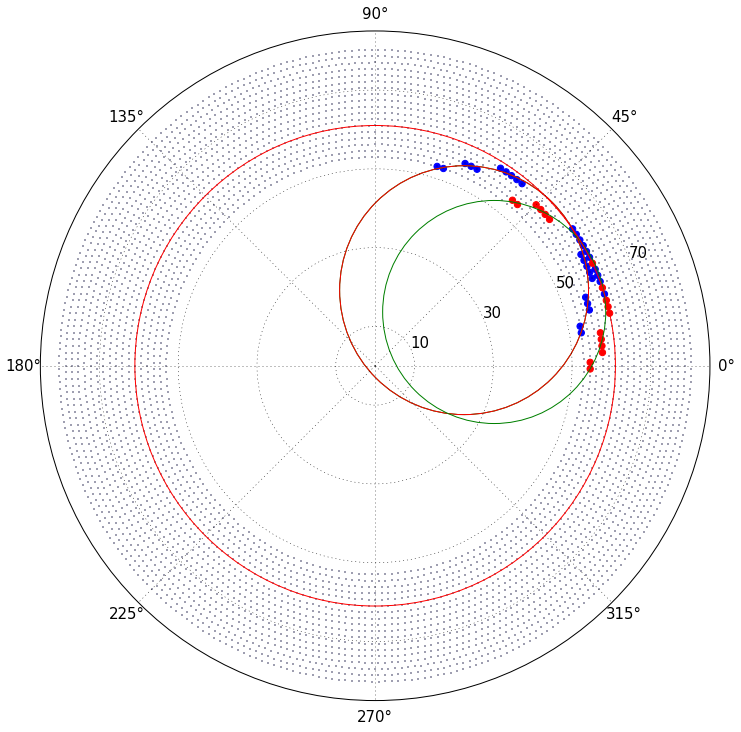

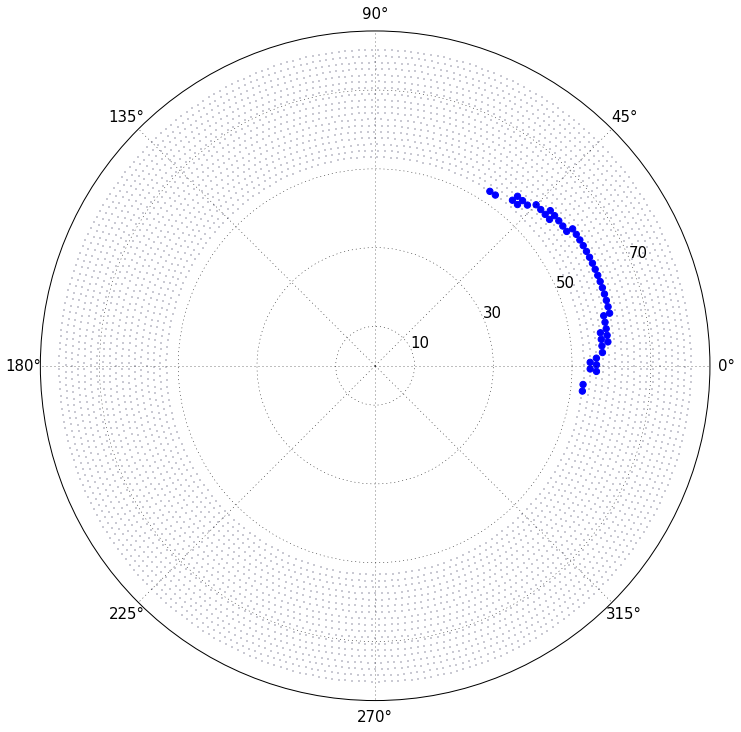

Event 9
Fit:31.5194867299
RANSAC Fit:33.0849397567

Fit:36.6651388699
RANSAC Fit:54.6



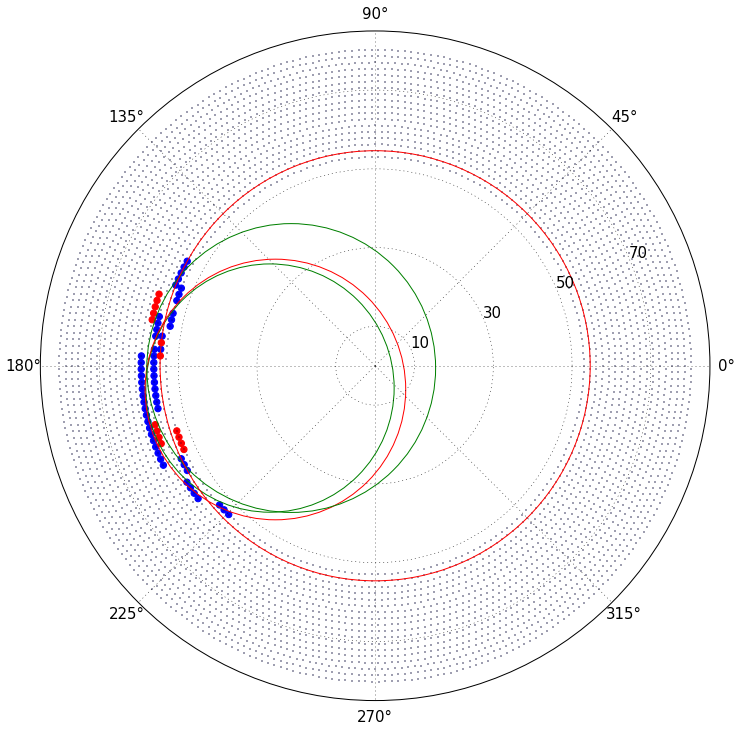

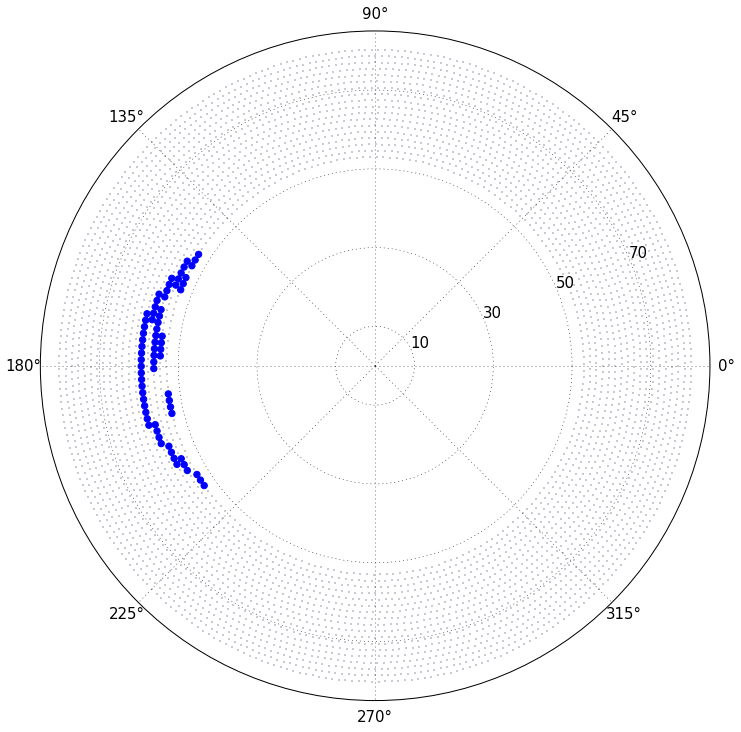

Event 10
Fit:32.5111460387
RANSAC Fit:32.5111460387

Fit:29.9860442055
RANSAC Fit:29.9860442055



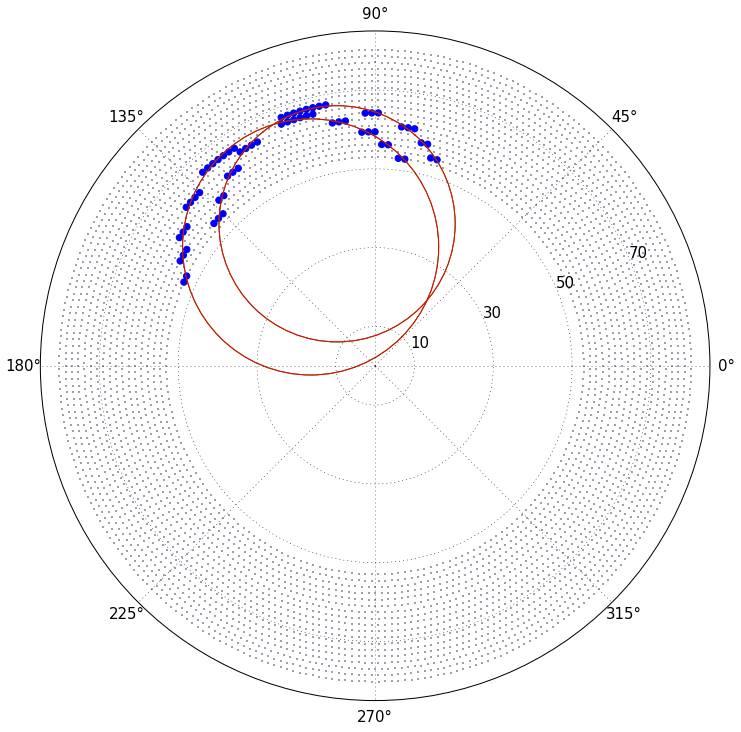

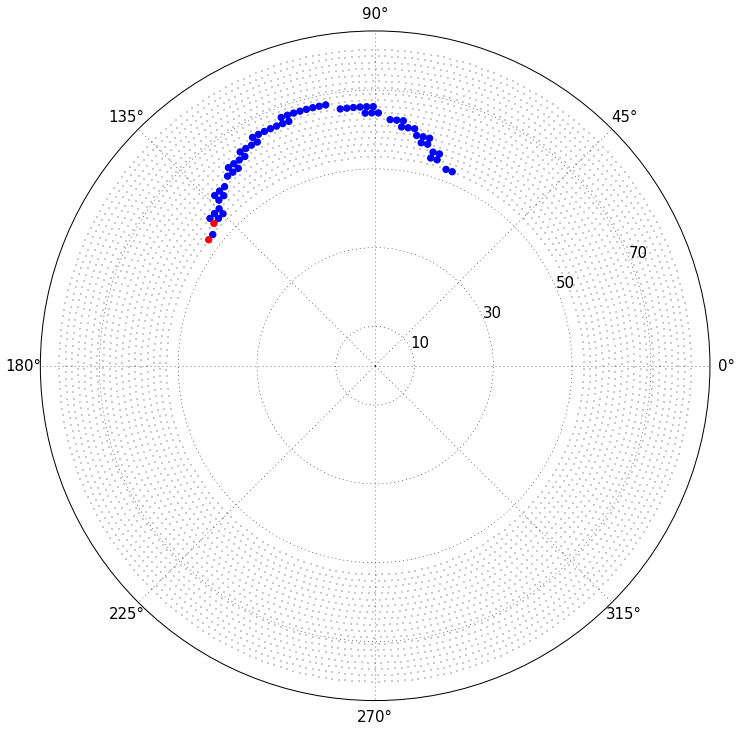

Event 11
Fit:32.3533423461
RANSAC Fit:59.4

Fit:31.5195249896
RANSAC Fit:57.8



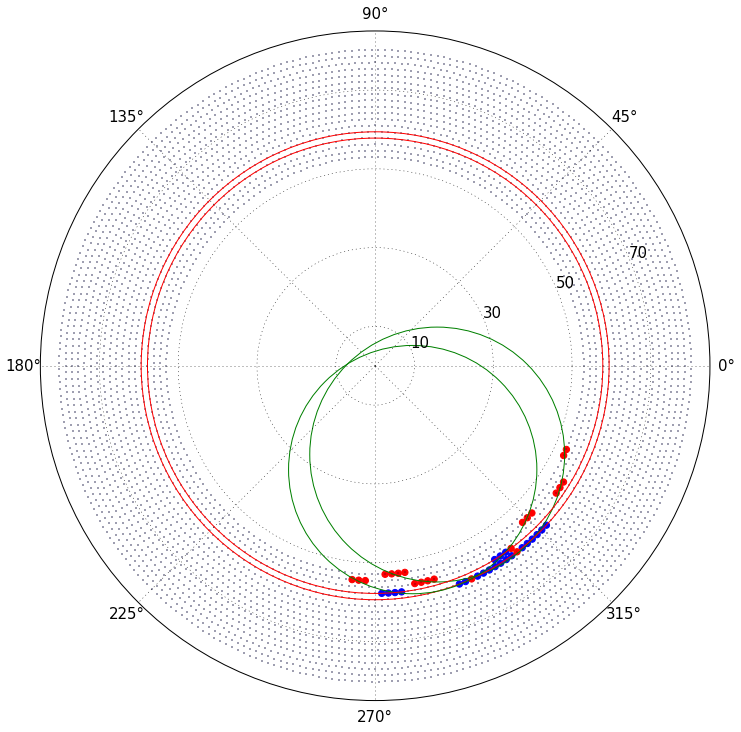

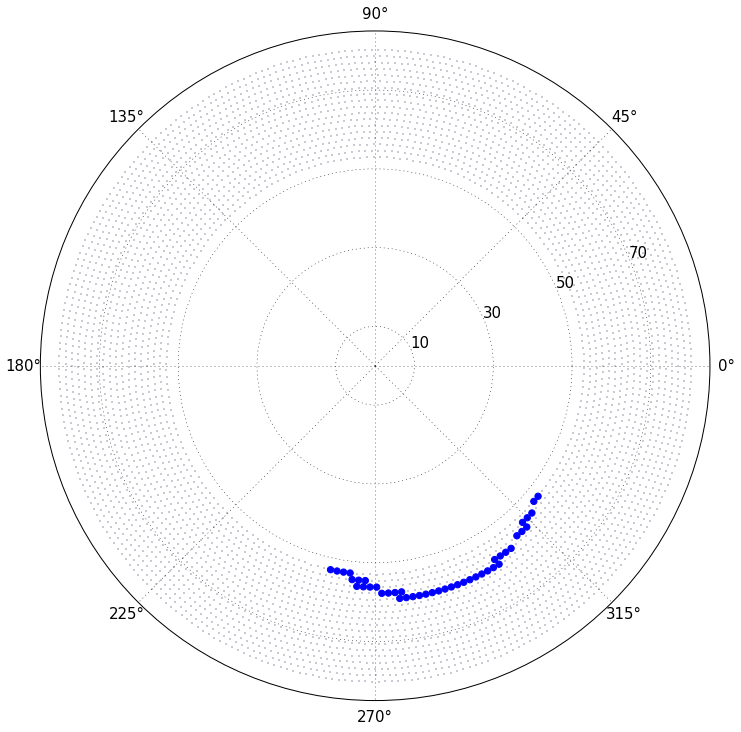

Event 12
Fit:31.8954318714
RANSAC Fit:31.8954318714

Fit:32.9312299966
RANSAC Fit:32.9312299966



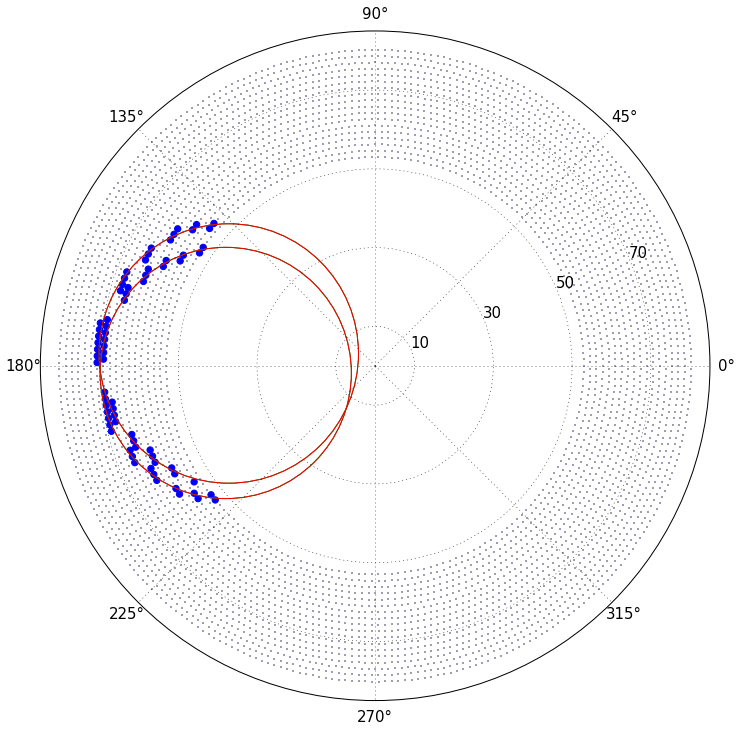

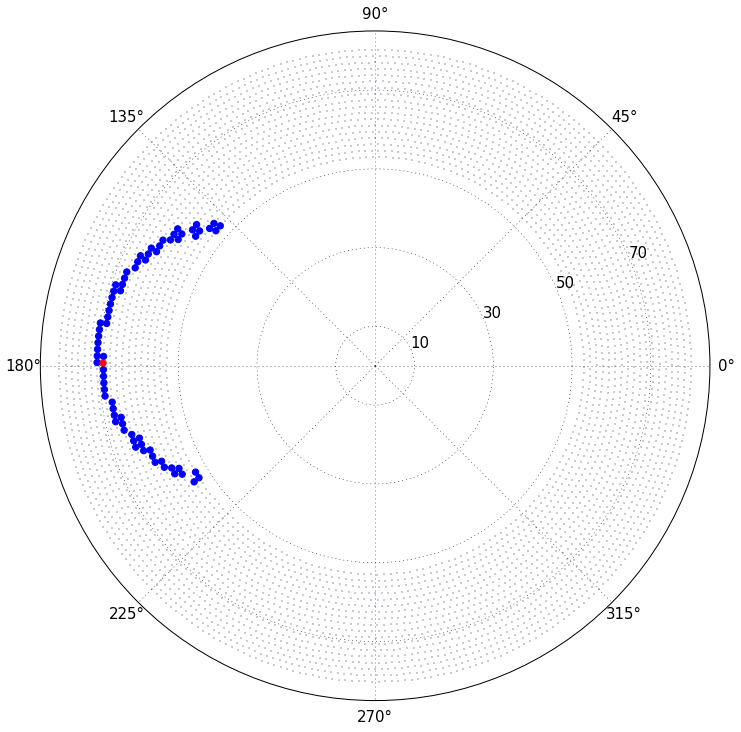

Event 13
Fit:34.4485225319
RANSAC Fit:34.4485225319

Fit:35.1690281659
RANSAC Fit:35.1690281659



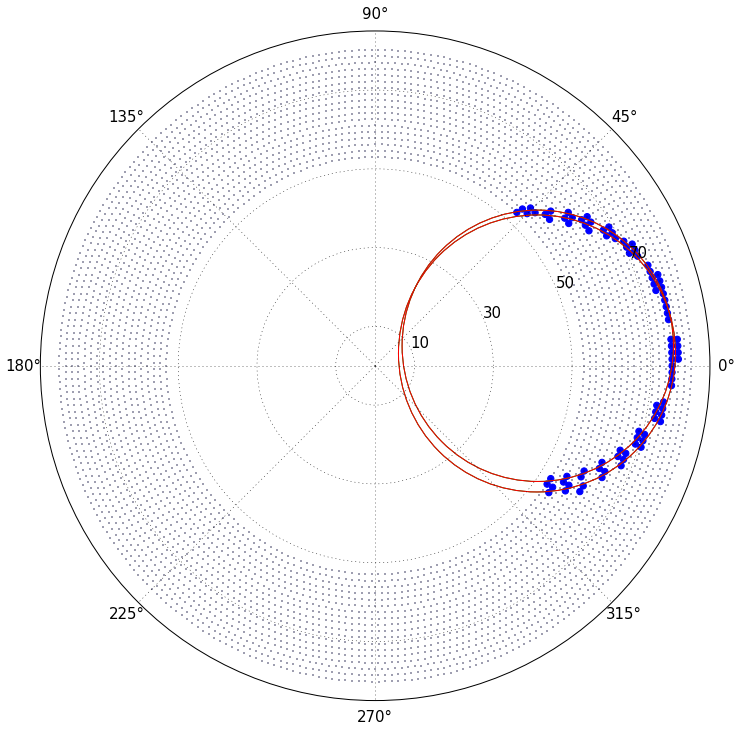

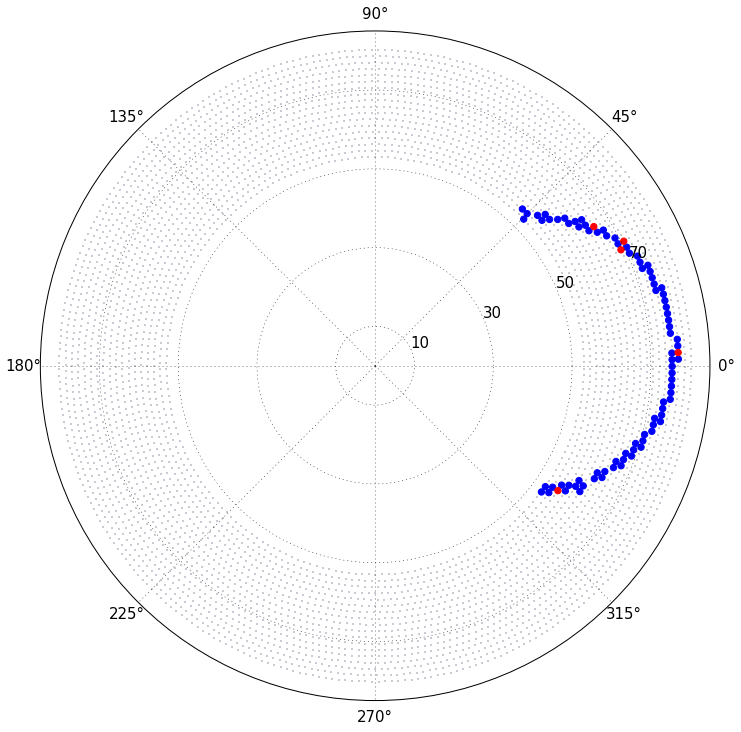

Event 14
Fit:31.381916359
RANSAC Fit:33.2162856001

Fit:32.2689746099
RANSAC Fit:33.3470122778



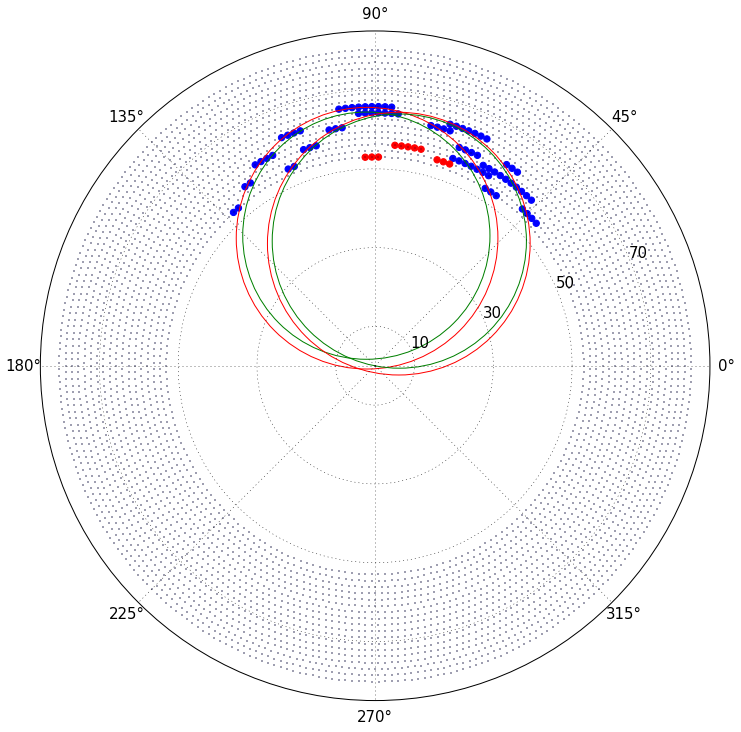

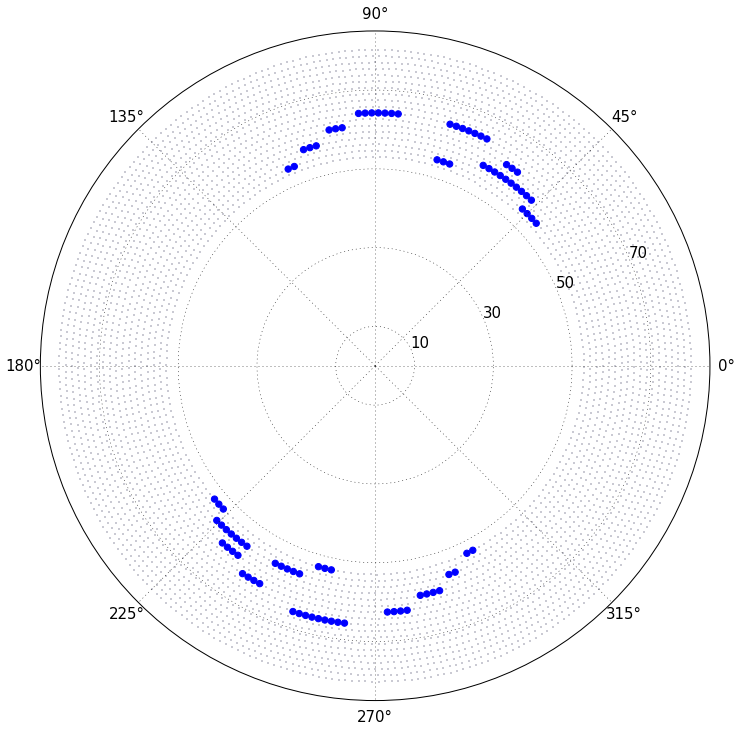

Event 15
Fit:33.8075107703
RANSAC Fit:33.8075107703

Fit:35.2930752278
RANSAC Fit:35.2930752278



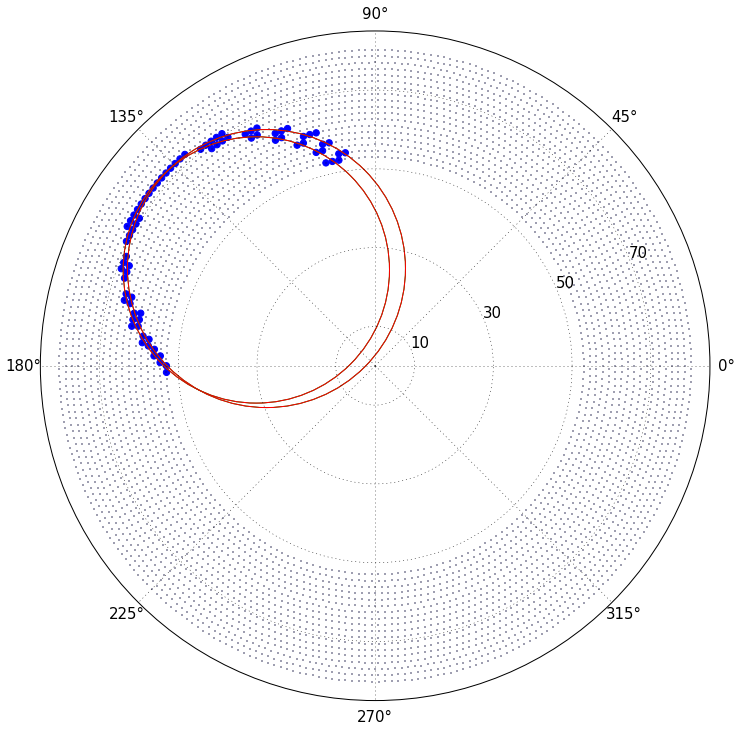

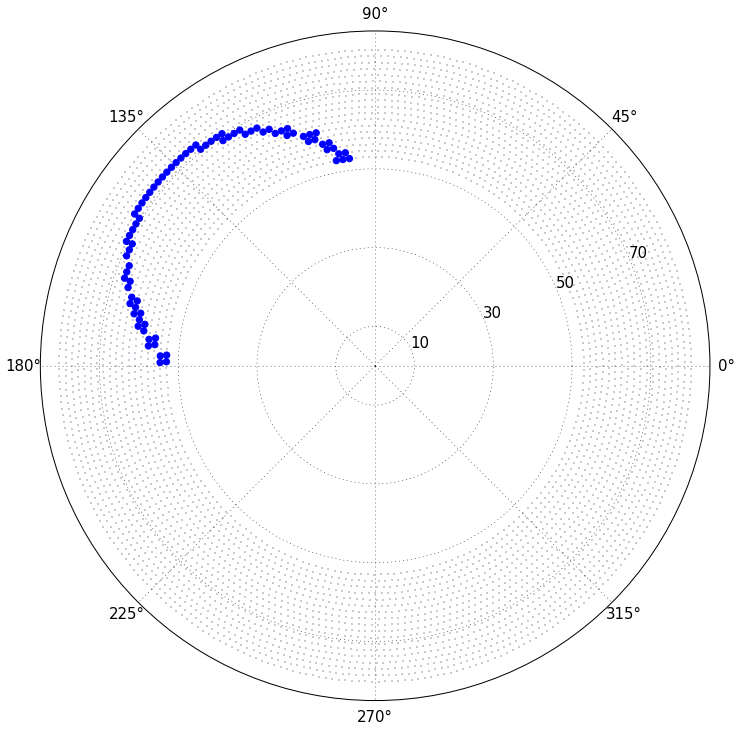

Event 16
Fit:31.6722836491
RANSAC Fit:33.6164686309

Fit:36.2385417447
RANSAC Fit:36.2493295295



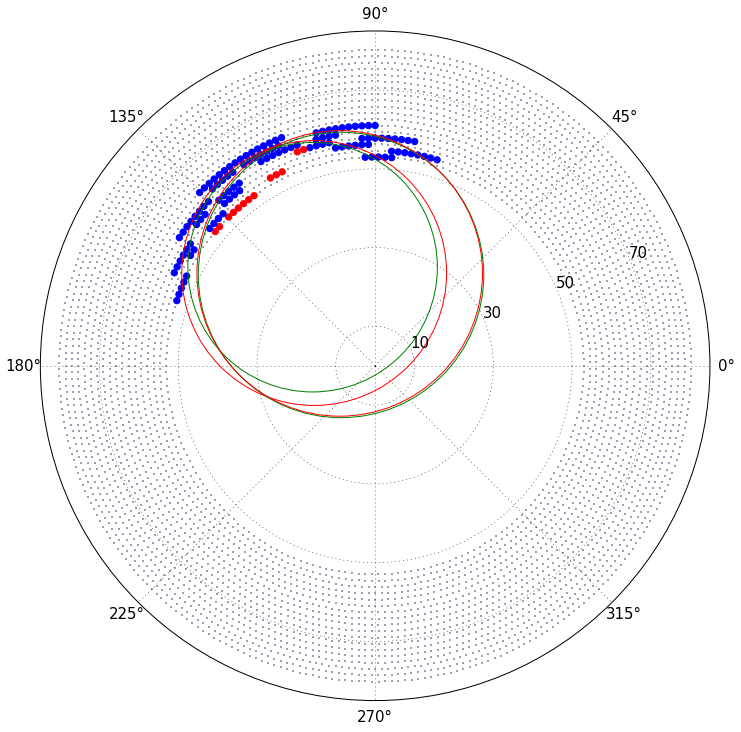

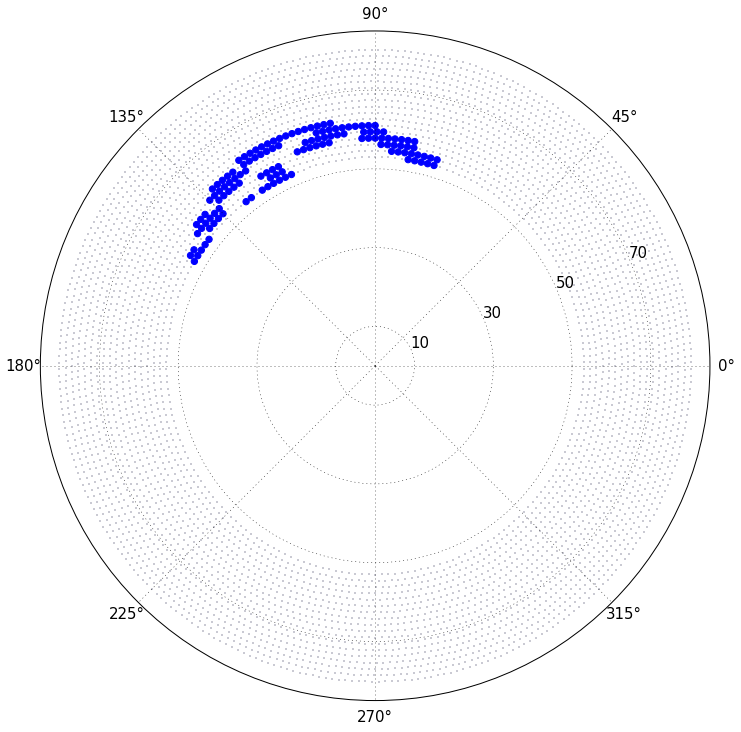

Event 17
Fit:35.4540349923
RANSAC Fit:35.2487521139

Fit:35.0379569
RANSAC Fit:35.0379569



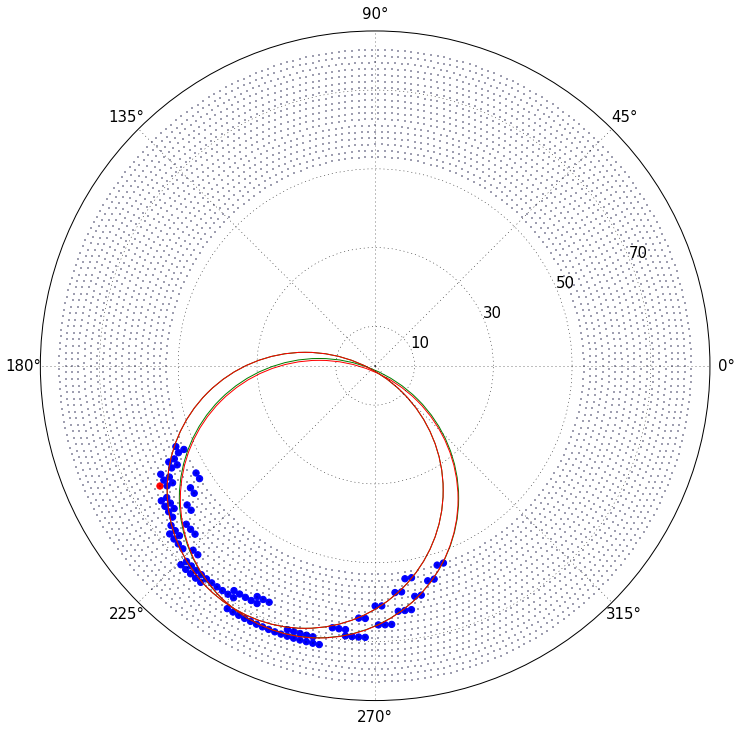

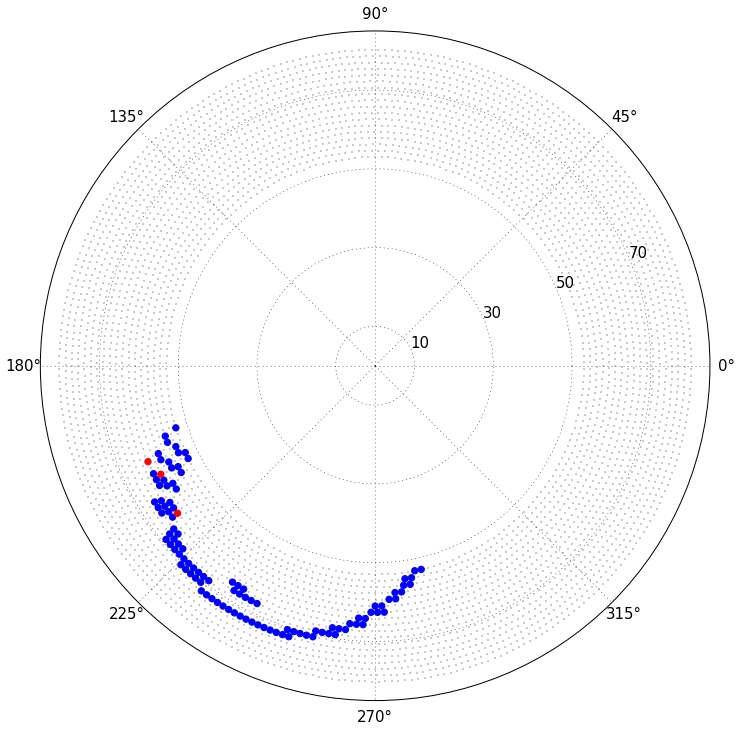

Event 18
Fit:34.012830439
RANSAC Fit:34.012830439

Fit:32.8460660557
RANSAC Fit:32.8460660557



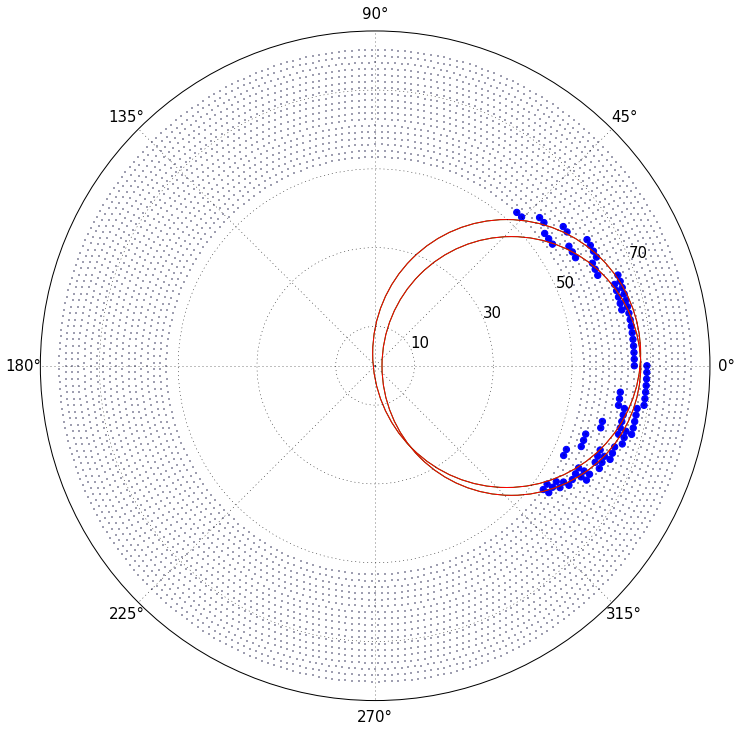

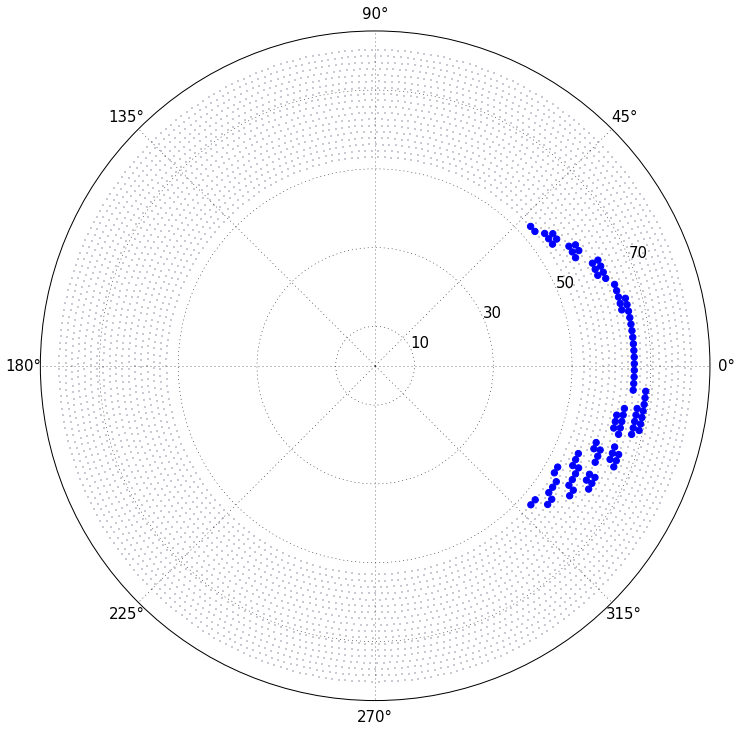

Event 19
Fit:34.00548892
RANSAC Fit:34.1813354295

Fit:33.8187468341
RANSAC Fit:33.8187468341



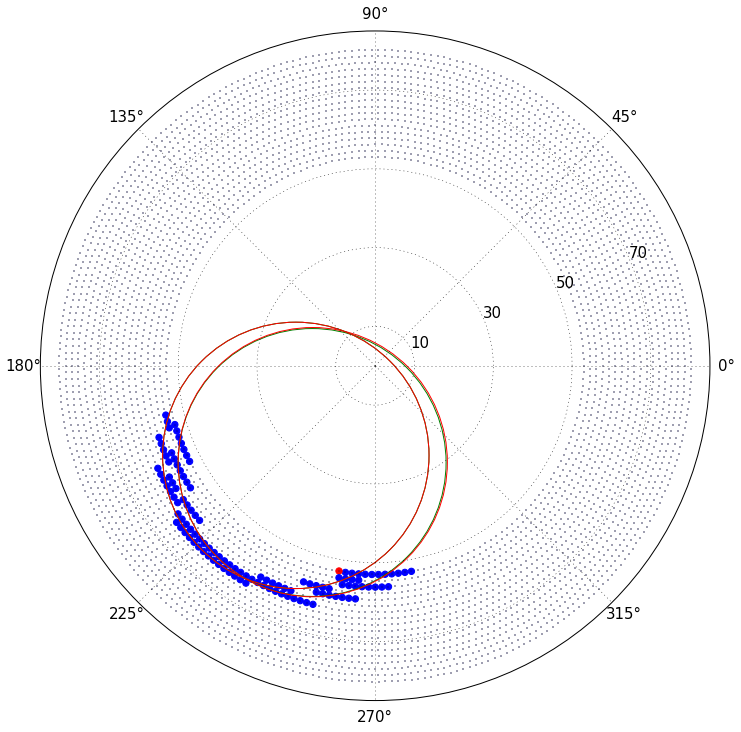

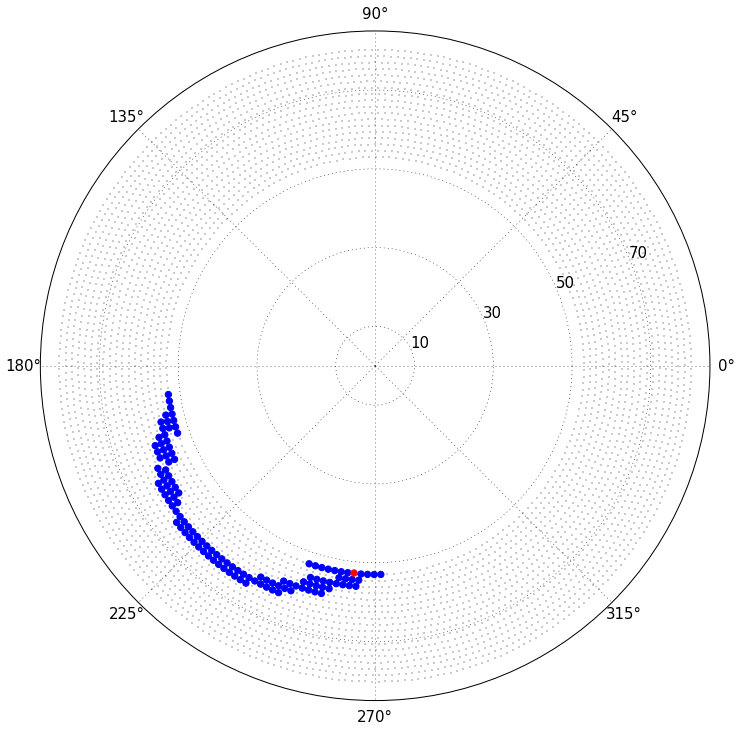

In [22]:
wire_x, wire_y = hits.cydet.get_points_xs_and_ys()

for evt in range(0,20):
    print "Event " + str(evt)
    
    # Get the even and odd signals
    even_sig, odd_sig = hits.get_hit_wires_even_odd(evt)
    # Skip if too few points
    if (even_sig.shape[0] < 13) or (odd_sig.shape[0] < 13):
        print "Skipped"
        continue
        
    # Initialze parameters
    x1, y1, r1 = np.zeros(2), np.zeros(2), np.zeros(2)
    x2, y2, r2 = np.zeros(2), np.zeros(2), np.zeros(2)

    for pol, signal in enumerate([even_sig, odd_sig]):
        
        # Get the points to fit
        fit_x, fit_y = wire_x[signal], wire_y[signal]
        fit_xy = np.vstack([fit_x,fit_y]).T
        # Linearize the equation
        fit_z = np.square(fit_x) + np.square(fit_y)

        # Fit line using all data
        model = linear_model.LinearRegression()
        model.fit(fit_xy, fit_z)

        # Robustly fit linear model with RANSAC algorithm
        model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
        model_ransac.fit(fit_xy, fit_z)
        inlier_mask = signal[model_ransac.inlier_mask_]
        outlier_mask = signal[np.logical_not(model_ransac.inlier_mask_)]

        # Plot the output
        labels = np.zeros(hits.cydet.n_points)
        labels[inlier_mask] = 1
        labels[outlier_mask] = 2
        plot_output(labels, hits.cydet)
        
        # Get the regular fit
        x1[pol], y1[pol], r1[pol] = get_circle(model.coef_[0], model.coef_[1] , model.intercept_)
        plot_add_circle(x1[pol], y1[pol], r1[pol])
        print "Fit:" + str(r1[pol])
        
        # Get the RANSAC fit
        x2[pol], y2[pol], r2[pol] = get_circle(model_ransac.estimator_.coef_[0][0], 
                         model_ransac.estimator_.coef_[0][1] , model_ransac.estimator_.intercept_)
        plot_add_circle(x2[pol], y2[pol], r2[pol], color="red")
        print "RANSAC Fit:" + str(r2[pol]) + "\n"
        
        # Make sure we're plotting all points
        assert len(inlier_mask) + len(outlier_mask) == len(signal),\
            "{} {}".format(len(inlier_mask) + len(outlier_mask), len(signal))
    show()    
    
    # Rotate the outputs together
    phi_even = np.arctan(y1[0]/x1[0])
    phi_odd  = np.arctan(y1[1]/x1[1])
    d_phi = phi_odd - phi_even
    plot_output(hits.get_hit_types(evt), hits.cydet, rotate_even=d_phi)
    show()

In [ ]:
plot_output(hits.get_hit_vector(evt), hits.cydet)